In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [198]:
data = pd.read_csv("data_input/fake_job_postings.csv")

In [199]:
data.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


In [200]:
data.shape

(17880, 18)

In [201]:
data.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [202]:
data.drop(['job_id','location','department','salary_range'],inplace=True,axis=1)

In [203]:
#fill NA with blank space
column = ['company_profile', 'description', 'requirements', 'benefits']
for i in column:
    data[i] = data[i].fillna('')

In [204]:
column_ = ['employment_type','required_experience','required_education','industry','function']
for i in column_:
    data[i] = data[i].fillna('unknown')

<h3>Exploratory Data Analysis</h3>

In [205]:
data.loc[data["fraudulent"] == 0, "fraudulent"] = "Real"
data.loc[data["fraudulent"] == 1, "fraudulent"] = "Fake"


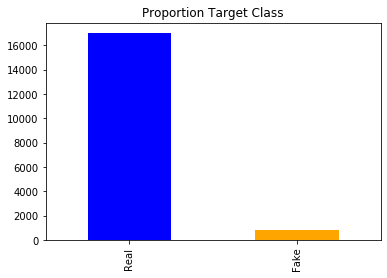

In [206]:
count_class=pd.value_counts(data["fraudulent"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

In [207]:
from collections import Counter
count1 = Counter(" ".join(data[data['fraudulent']=='Real']['company_profile']).\
                 split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in company profile real job", 1 : "count"})

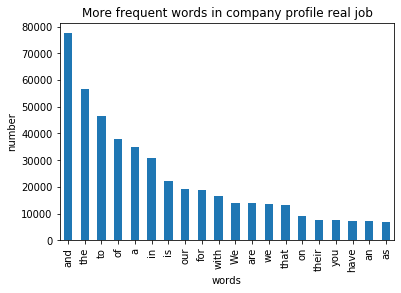

In [208]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in company profile real job"]))
plt.xticks(y_pos, df1["words in company profile real job"])
plt.title('More frequent words in company profile real job')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [209]:
count2 = Counter(" ".join(data[data['fraudulent']=='Fake']['description']).\
                 split()).most_common(20)
df2 = pd.DataFrame.from_dict(count1)
df2 = df2.rename(columns={0: "words in description real job", 1 : "count"})

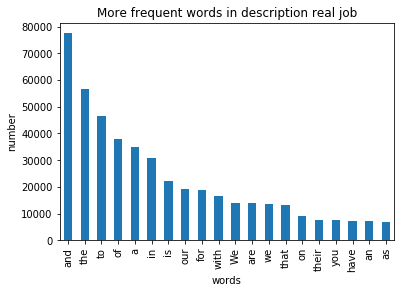

In [210]:
df2.plot.bar(legend = False)
y_pos = np.arange(len(df2["words in description real job"]))
plt.xticks(y_pos, df2["words in description real job"])
plt.title('More frequent words in description real job')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

<h3>Text Mining</h3>

In [211]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\litaimut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [212]:
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')

In [213]:
text_df = data[['title','company_profile', 'description', 'requirements', 'benefits',\
          'employment_type','required_experience','required_education','industry','function']]
main_text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = data['fraudulent']

print(len(main_text))
print(len(target))

17880
17880


In [214]:
main_text

0        Marketing Intern,We're Food52, and we've creat...
1        Customer Service - Cloud Video Production,90 S...
2        Commissioning Machinery Assistant (CMA),Valor ...
3        Account Executive - Washington DC,Our passion ...
4        Bill Review Manager,SpotSource Solutions LLC i...
                               ...                        
17875    Account Director - Distribution ,Vend is looki...
17876    Payroll Accountant,WebLinc is the e-commerce p...
17877    Project Cost Control Staff Engineer - Cost Con...
17878    Graphic Designer,,Nemsia Studios is looking fo...
17879    Web Application Developers,Vend is looking for...
Length: 17880, dtype: object

<h4>Remove Special Character</h4>

In [215]:
import re
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

main_text = main_text.apply(remove_between_square_brackets)
main_text = main_text.apply(remove_special_characters)


<>:4: DeprecationWarning: invalid escape sequence \[
<>:4: DeprecationWarning: invalid escape sequence \[
<>:4: DeprecationWarning: invalid escape sequence \[
<ipython-input-215-bd74c9906aaa>:4: DeprecationWarning: invalid escape sequence \[
  return re.sub('\[[^]]*\]', '', text)


<h4>Tokenizer</h4>

In [216]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

main_text = main_text.apply(lambda x: tokenizer.tokenize(x))

<h4>Remove Stopwords</h4>

In [217]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopword_list]
    return words

main_text = main_text.apply(lambda x : remove_stopwords(x))

<h4>Join Text</h4>

In [218]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

main_text = main_text.apply(lambda x : combine_text(x))

df = pd.concat([main_text,target],axis=1)

In [219]:
df.rename(columns={0: "text"},inplace=True)

In [220]:
df.head(2)

,text,fraudulent
0,Marketing InternWere Food52 weve created groun...,Real
1,Customer Service Cloud Video Production90 Seco...,Real


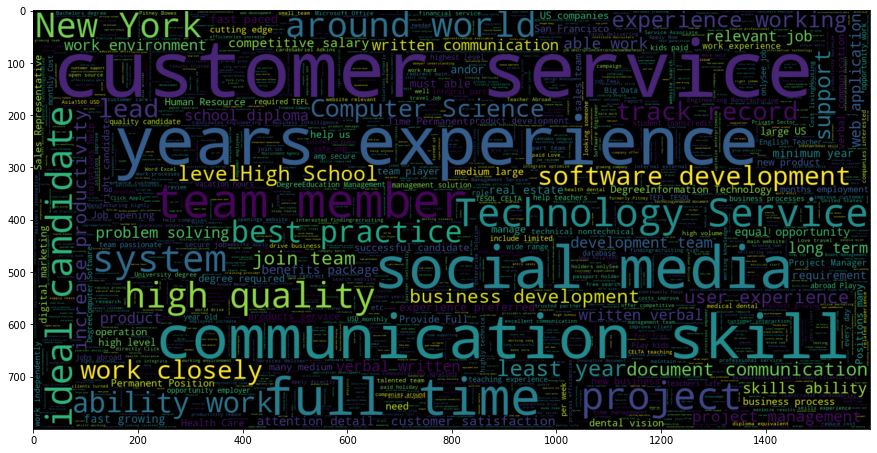

In [221]:
from wordcloud import WordCloud

plt.figure(figsize = (15,15)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 'Real'].text))
plt.imshow(wc , interpolation = 'bilinear')

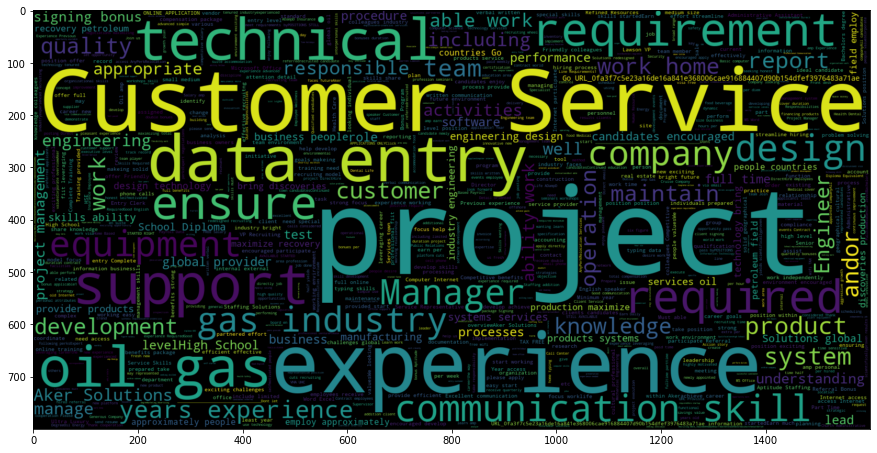

In [222]:
plt.figure(figsize = (15,15)) # Text that is fraudulent
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 'Fake'].text))
plt.imshow(wc , interpolation = 'bilinear')

<h3>Modelling</h3>

<h4>Naive Bayes</h4>

In [223]:
from sklearn.model_selection import train_test_split
#setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(df.text, df.fraudulent, test_size=0.2, random_state=42)

In [224]:
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

cv_train=cv.fit_transform(X_train)
cv_test=cv.transform(X_test)

print('BOW_cv_train:',cv_train.shape)
print('BOW_cv_test:',cv_test.shape)

BOW_cv_train: (14304, 1844678)
BOW_cv_test: (3576, 1844678)


In [225]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

tfidf_train=tfidf.fit_transform(X_train)

tfidf_test=tfidf.transform(X_test)
print('Tfidf_train:',tfidf_train.shape)
print('Tfidf_test:',tfidf_test.shape)

Tfidf_train: (14304, 1844678)
Tfidf_test: (3576, 1844678)


In [226]:
from sklearn.naive_bayes import MultinomialNB

#training the model
mnb=MultinomialNB()

mnb_bow=mnb.fit(cv_train,y_train)
print(mnb_bow)

mnb_tfidf=mnb.fit(tfidf_train,y_train)
print(mnb_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [227]:
mnb_bow_predict=mnb.predict(cv_test)

mnb_tfidf_predict=mnb.predict(tfidf_test)

In [228]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

mnb_bow_score=accuracy_score(y_test,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

mnb_tfidf_score=accuracy_score(y_test,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.939317673378076
mnb_tfidf_score : 0.9493847874720358


In [233]:
import warnings
warnings.filterwarnings('always') 

mnb_bow_report = classification_report(y_test,mnb_bow_predict)
print(mnb_bow_report)

              precision    recall  f1-score   support

        Fake       0.37      0.29      0.33       181
        Real       0.96      0.97      0.97      3395

    accuracy                           0.94      3576
   macro avg       0.67      0.63      0.65      3576
weighted avg       0.93      0.94      0.94      3576

